# Fine-tuning for Color Swatch
By William Caban

Fine-tuning an LLM to generate 10 colors for an [analogous harmony](https://en.wikipedia.org/wiki/Harmony_(color)#Analogous_colors) color palette.

---

## Loading, formatting & splitting the dataset

In [1]:
import pandas as pd
import json, re, sys
from tqdm.notebook import tqdm
from datasets import load_dataset

DEBUG=False

In [2]:
# download dataset
DATASET="caperaven/color_swatch"
dataset = load_dataset(DATASET)

In [3]:
# features and size of dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'output'],
        num_rows: 610
    })
})

In [4]:
_system = "You are a cautious assistant. You are an expert in color palette. " + \
          "Given a Color generate a JSON array of 10 colors for an analogous harmony palette."

_template = '<|system|>\n{system}\n<|user|>\nColor: {color}\n<|assistant|>\n{swatch}' # Not adding <|endoftext|>

In [5]:
def prepare_dataset(local_dataset):
    global _system
    global _template
    
    local_dataset['text'] = _template.format(system=_system,
                                             color=local_dataset['input'].strip(),
                                             swatch=local_dataset['output'])
    return local_dataset

In [6]:
# create a "text" column with combined prompt
dataset2 = dataset.map(prepare_dataset)['train']
dataset2

Dataset({
    features: ['input', 'output', 'text'],
    num_rows: 610
})

In [7]:
print(dataset2['text'][0])

<|system|>
You are a cautious assistant. You are an expert in color palette. Given a Color generate a JSON array of 10 colors for an analogous harmony palette.
<|user|>
Color: #0000d6
<|assistant|>
['#0000d6', '#1c00db', '#3d00e0', '#5300e8', '#6002ee', '#7e3ff2', '#9965f4', '#b794f6', '#d4bff9', '#efe5fd']


In [8]:
# Split the dataset
split_dataset = dataset2.train_test_split(test_size=0.1) # 10% for test
split_dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'text'],
        num_rows: 549
    })
    test: Dataset({
        features: ['input', 'output', 'text'],
        num_rows: 61
    })
})

In [9]:
# retrieve a sample
split_dataset['train'][0]

{'input': '#ec00a2',
 'output': ['#960093',
  '#b70099',
  '#ca009d',
  '#de00a0',
  '#ec00a2',
  '#fb00b2',
  '#ff00bf',
  '#ff77d1',
  '#ffb2e3',
  '#ffe1f4'],
 'text': "<|system|>\nYou are a cautious assistant. You are an expert in color palette. Given a Color generate a JSON array of 10 colors for an analogous harmony palette.\n<|user|>\nColor: #ec00a2\n<|assistant|>\n['#960093', '#b70099', '#ca009d', '#de00a0', '#ec00a2', '#fb00b2', '#ff00bf', '#ff77d1', '#ffb2e3', '#ffe1f4']"}

In [10]:
# convert split to Pandas dataframe
df_train = pd.DataFrame(split_dataset['train'])
df_test = pd.DataFrame(split_dataset['test'])

In [11]:
split_dataset.save_to_disk('color_swatch_split')

Saving the dataset (0/1 shards):   0%|          | 0/549 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/61 [00:00<?, ? examples/s]

---
## Fine-Tune Model

In [12]:
from mlx_lm import generate, load

In [13]:
# read functions from existing notebooks
%run notebooks/InterviewModel.ipynb

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Help on function extract_hex_list in module __main__:

extract_hex_list(text)
    return a list of up to 10 hex color numbers in the original text

Help on function to_prompt in module __main__:

to_prompt(color, tokenizer)

Help on function query in module __main__:

query(prompt, model, tokenizer, DEBUG=False)

Help on function interview in module __main__:

interview(df_set, model_cname, model, tokenizer)

None None None None


Importa all packages required for fine-tuning

In [14]:
from pathlib import Path

import matplotlib.pyplot as plt
import mlx.core as mx
import mlx.optimizers as optim

from mlx.utils import tree_flatten
from mlx_lm import load, generate
from mlx_lm.tuner import train, evaluate, TrainingArgs
from mlx_lm.tuner import linear_to_lora_layers

Setup the LoRA parameters and make the training arguments.

Following reference implementation from [MLX LM LoRA Fine Tune.ipynb](https://gist.github.com/awni/773e2a12079da40a1cbc566686c84c8f)

The LoRA parameters to attend to are:
- `lora_layers`: The number of Transformer blocks from the top of the model to adapt.
- `rank`: The rank of the low-rank adapters. A larger rank implies more adapter parameters per linear layer.
- `scale`: This is the constant  that scales the low-rank update.

In [15]:
# Make a directory to save the adapter config and weights
adapter_path = Path("adapters")
adapter_path.mkdir(parents=True, exist_ok=True)

# Lora config for fine-tuning
lora_config = {
 "lora_layers": 8,
 "lora_parameters": {
    "rank": 8,
    "scale": 20.0,
    "dropout": 0.0,
}}

# Save the LoRA config to the adapter path
with open(adapter_path / "adapter_config.json", "w") as fid:
    json.dump(lora_config, fid, indent=4)    

# size_train_dataset / batch_size = iter_per_epochs
# 549 size_train_dataset / 4 batch_size = ~130 iter_per_epoch
# 1500 iter / 130 iter_per_epoch = ~11.5 epochs
# num_of_training_samples_shown = batch_size * iterations
#
# https://github.com/ml-explore/mlx-examples/blob/3f337e0f0ad766379ff6325e29dc6b9b2328e960/llms/mlx_lm/tuner/trainer.py#L31
# larger batch can lead to significant degradation in the quality of the model (lack of generalization)
training_args = TrainingArgs(
    batch_size = 4,          # default 4   - 
    iters = 1_500,           # default 100 - iterations to train for
    steps_per_report = 25,   # default 10  -
    steps_per_eval = 25,     # default 200 - batches per epoch
    steps_per_save = 50,     # default 100 -
    adapter_file = adapter_path / "adapters.safetensors",
    grad_checkpoint = False, # defaullt False
)

In [16]:
# Specify the model checkpoint
checkpoint = "instructlab/granite-7b-lab"

# Load the corresponding model and tokenizer for finetuning (ft)
model_ft, tokenizer_ft = load(path_or_hf_repo=checkpoint, tokenizer_config={'legacy': 'false'})

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [17]:
# Freeze the base model
model_ft.freeze()

# Convert linear layers to lora layers
linear_to_lora_layers(model_ft, 
                      lora_config["lora_layers"], 
                      lora_config["lora_parameters"]
                     )

num_train_params = (
    sum(v.size for _, v in tree_flatten(model_ft.trainable_parameters()))
)

print(f"Number of trainable parameters: {num_train_params}")

Number of trainable parameters: 1048576


In [18]:
# Put the model in training mode
model_ft.train()

# Define the optimizer
optimizer = optim.Adam(learning_rate=1e-5)

# Make a class to record the training stats
# Early stopping: Stop if validation loss starts to increase or stop improving, else keep training
class Metrics:
    train_losses = []
    val_losses = []
    def on_train_loss_report(self, info):
        self.train_losses.append((info["iteration"], info["train_loss"]))
        # print(f"DEBUG on_train METRICS: {info}")
    def on_val_loss_report(self, info):
        self.val_losses.append((info["iteration"], info["val_loss"]))
        # print(f"DEBUG on_val METRICS: {info}")\# plot metrics
        # if len(self.train_losses) > 1 and len(self.val_losses) > 1:
        #     train_iterations, train_losses = zip(*self.train_losses)
        #     val_iterations, val_losses = zip(*self.val_losses)
        #     plt.plot(train_iterations,train_losses, label='Training Loss')
        #     plt.plot(val_iterations, val_losses, label='Validation Loss')
        #     plt.xlabel('Iterations')
        #     plt.ylabel('Loss')
        #     plt.legend(loc='best')
        #     plt.show()
    def __getattr__(self, name):
        print(f"INFO: Ignoring call to undefined method {name}.")
        ## to raise an exception when invoking a non-existent method
        # def method(*args, **kwargs):
        #     raise Exception(f'Method "{name}" not yet implemented')
        # return method

metrics = Metrics()

In [19]:
%%time
# Train model
train(
    model=model_ft,
    tokenizer=tokenizer_ft,
    args=training_args,
    optimizer=optimizer,
    train_dataset=split_dataset['train']['text'],
    val_dataset=split_dataset['test']['text'],
    training_callback=metrics # callbacks
)

Starting training..., iters: 1500
Iter 1: Val loss 3.149, Val took 25.161s
Iter 25: Val loss 1.257, Val took 26.801s
Iter 25: Train loss 2.211, Learning Rate 1.000e-05, It/sec 11.332, Tokens/sec 5887.861, Trained Tokens 12990, Peak mem 26.443 GB
Iter 50: Val loss 0.918, Val took 25.504s
Iter 50: Train loss 0.992, Learning Rate 1.000e-05, It/sec 12.419, Tokens/sec 6462.292, Trained Tokens 25999, Peak mem 26.443 GB
Iter 50: Saved adapter weights to adapters/adapters.safetensors and adapters/0000050_adapters.safetensors.
Iter 75: Val loss 0.827, Val took 28.331s
Iter 75: Train loss 0.836, Learning Rate 1.000e-05, It/sec 11.807, Tokens/sec 6110.508, Trained Tokens 38937, Peak mem 26.443 GB
Iter 100: Val loss 0.757, Val took 25.434s
Iter 100: Train loss 0.770, Learning Rate 1.000e-05, It/sec 12.588, Tokens/sec 6530.954, Trained Tokens 51908, Peak mem 26.443 GB
Iter 100: Saved adapter weights to adapters/adapters.safetensors and adapters/0000100_adapters.safetensors.
Iter 125: Val loss 0.720

In [20]:
# Save fine-tuned model as safetensor
model_ft.save_weights(f"{adapter_path}/fine_tuned_model.safetensors")

___
## Plotting Training & Validation Loss

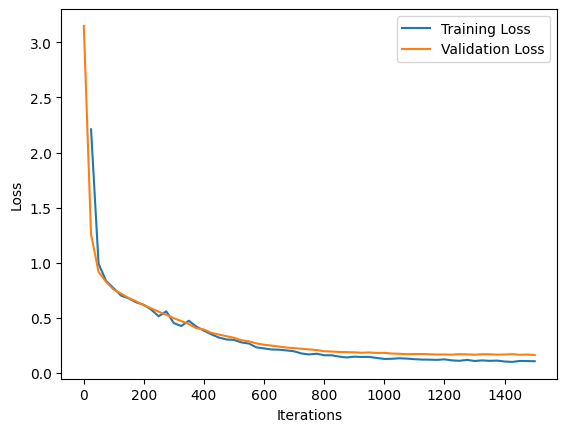

In [21]:
# read metrics
train_iterations, train_losses = zip(*metrics.train_losses)
val_iterations, val_losses = zip(*metrics.val_losses)

# plot metrics
plt.plot(train_iterations,train_losses, label='Training Loss')
plt.plot(val_iterations, val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [22]:
_system = "You are a cautious assistant. You are an expert in color palette. " + \
          "Given a Color generate a JSON array of 10 colors for an analogous harmony palette."

color=split_dataset['test'][0]['input']

prompt = to_prompt(color, tokenizer_ft)

In [23]:
response1=query(prompt, model0, tokenizer0)

In [24]:
response2=query(prompt, model_ft, tokenizer_ft)

In [25]:
swatch0=split_dataset['test'][0]['output']
swatch1=response1
swatch2=response2

In [26]:
print(f"swatch0={swatch0}\nswatch1={swatch1}\nswatch2={swatch2}")

swatch0=['#E65100', '#EF6C00', '#F57C00', '#FB8C00', '#FF9800', '#FFA726', '#FFB74D', '#FFCC80', '#FFE0B2', '#FFF3E0']
swatch1=['#FFC107', '#FF9800', '#FFFF00', '#F4F4F4', '#FF5722', '#FF80AB', '#E9ECEC', '#9E9E9E', '#607D8B', '#3F51B5']
swatch2=['#BF360C', '#D84158', '#E5535B', '#F45160', '#FF5073', '#FD8760', '#FEB24C', '#FCFF81', '#F5FFBC', '#F0F4FA']


---
## Interview model

In [27]:
########################################
# FIXME: number of entries to run
df_granite=interview(df_test.head(10), model_cname="granite_7b_lab", model=model0, tokenizer=tokenizer0)

Interviewing granite_7b_lab: 0it [00:00, ?it/s]

In [28]:
df=interview(df_granite, model_cname="fine_tuned", model=model_ft, tokenizer=tokenizer_ft)

Interviewing fine_tuned: 0it [00:00, ?it/s]

In [29]:
# read functions from existing notebooks
%run notebooks/Visualization.ipynb

Help on function plot_swatch in module __main__:

plot_swatch(swatch0, swatch1, swatch2, titles=['ground-truth', 'pre-trained', 'fine-tuned'], DEBUG=False)
    Plot swatches for color gradients. On size mismatch it will use the size of shortest list.

    swatch0:  Python list of hex colors
    swatch1:  Python list of hex colors
    swatch2:  Python list of hex colors
    titles:   List of titles to use for the swatch lists.
              If 3rd label is None, it will not plot the 3rd swatch.
    DEBUG:    Default to False. When True, additional print statements are executed.

None


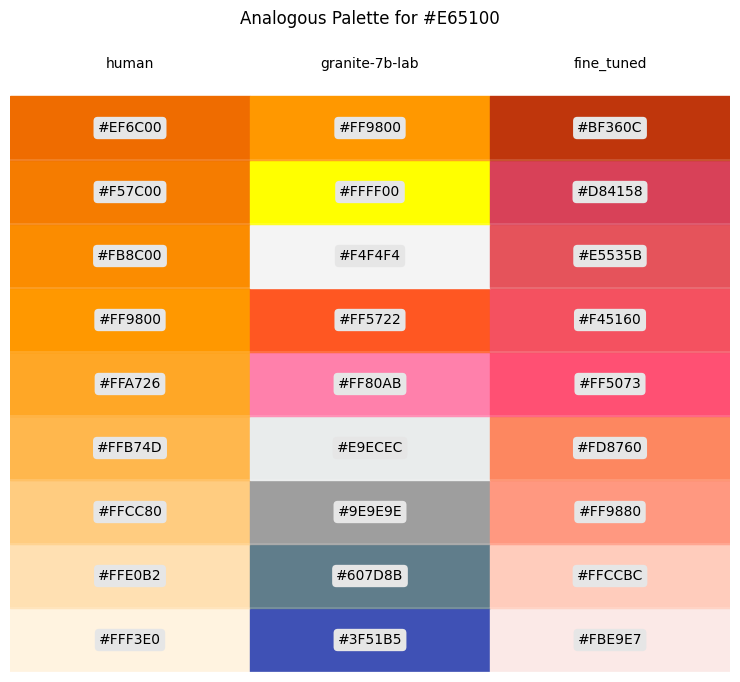

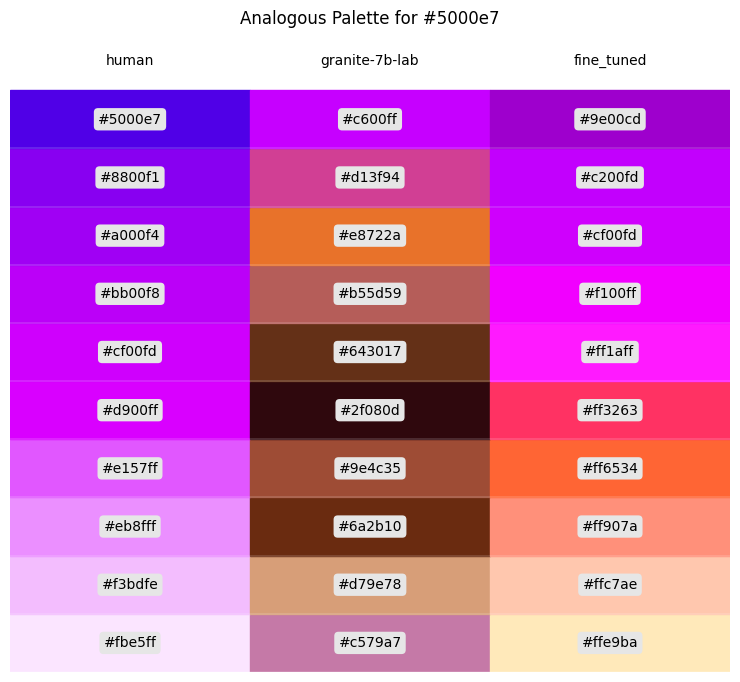

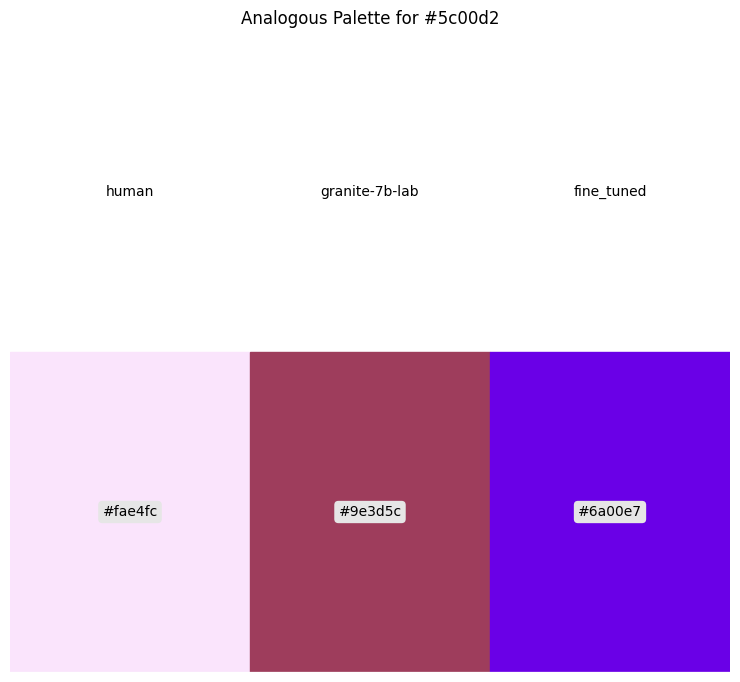

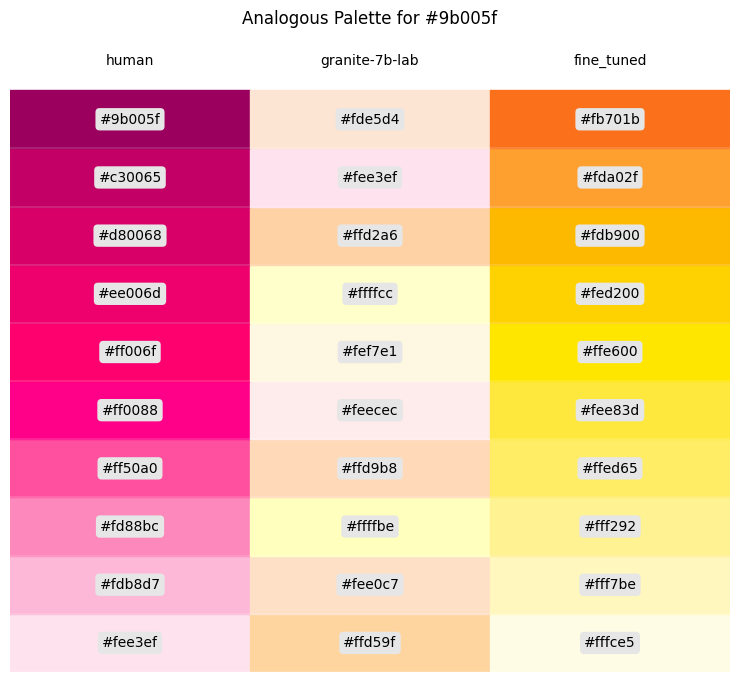

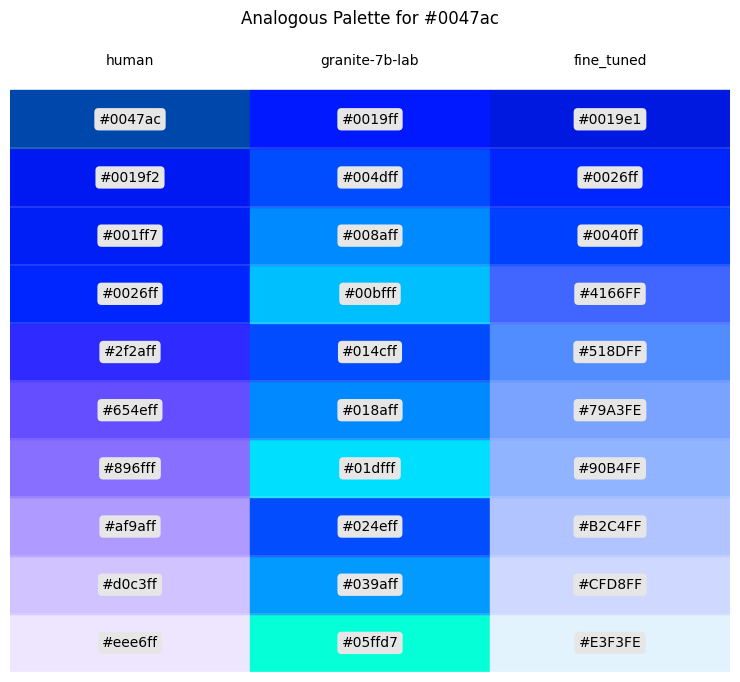

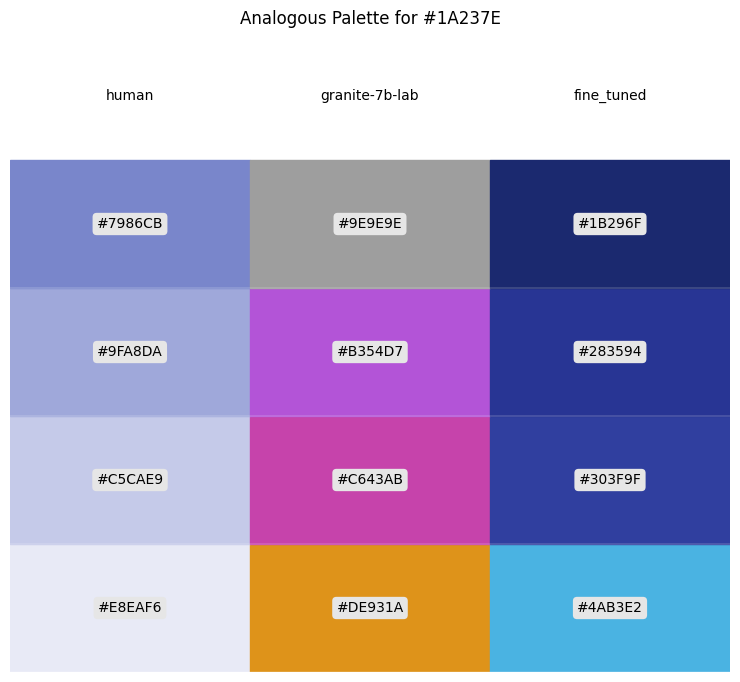

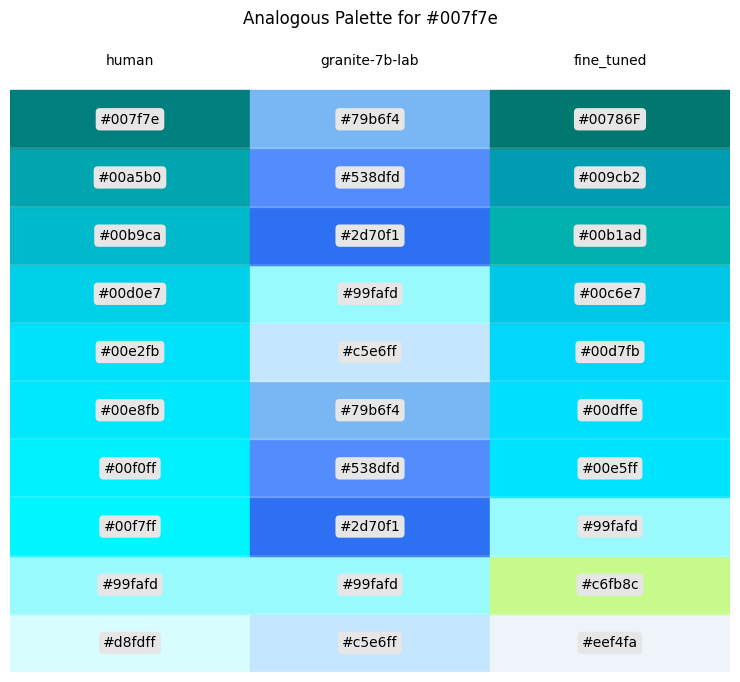

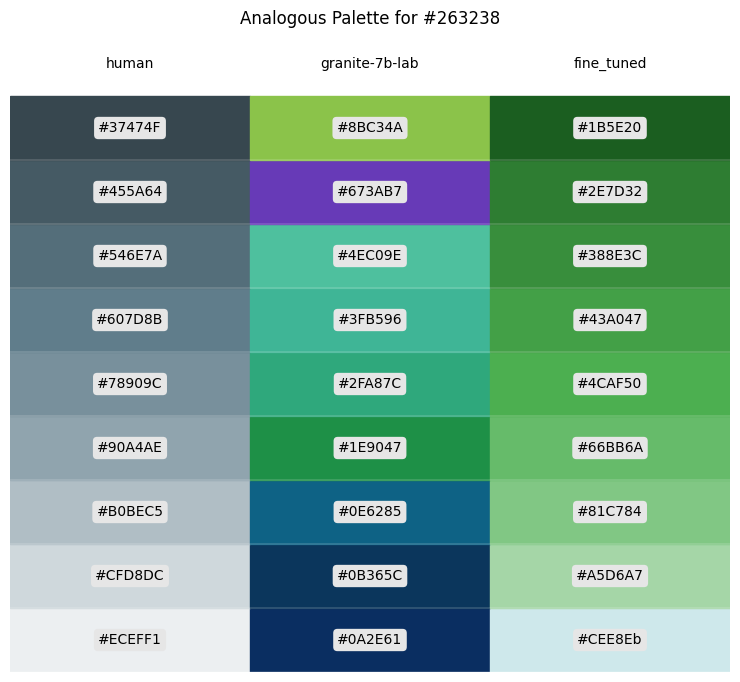

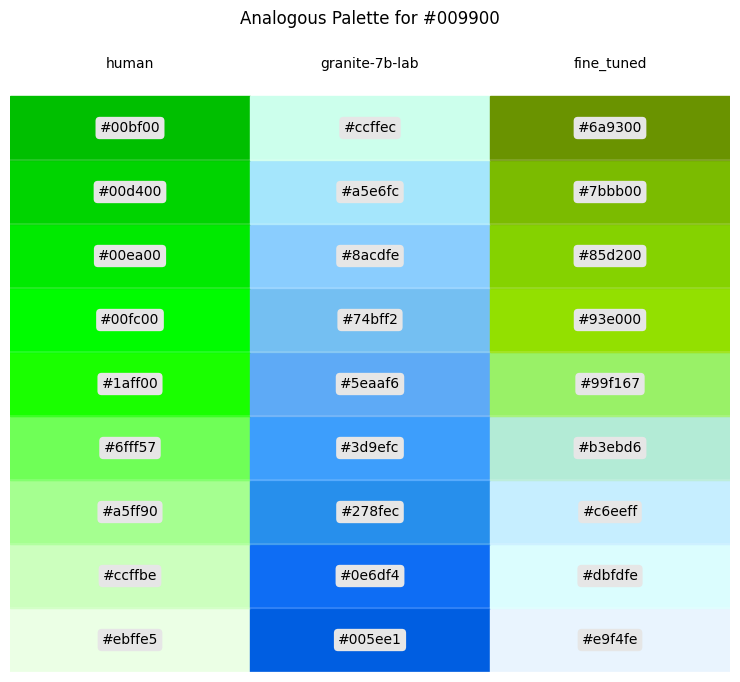

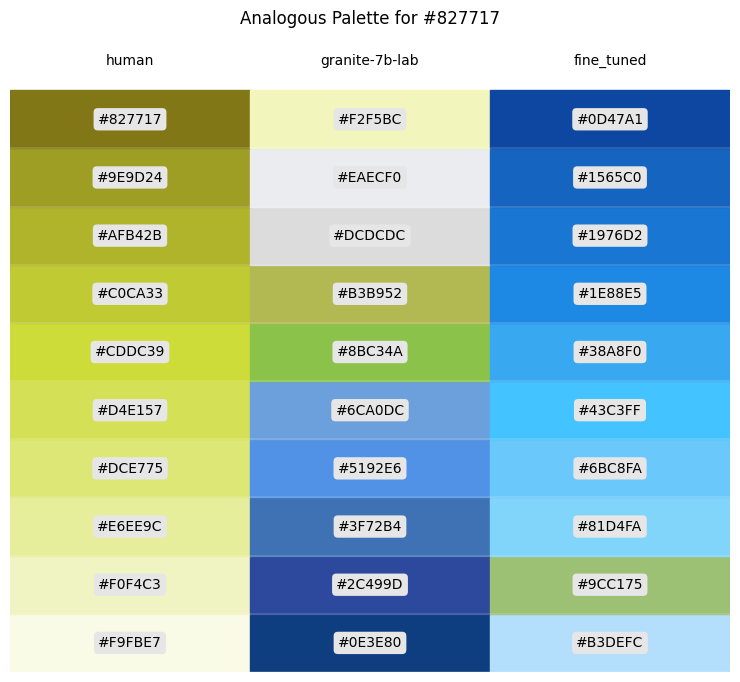

In [30]:
for indx, row in df.iterrows():
    swatch0 = row['output']
    swatch1 = extract_hex_list(row['granite_7b_lab'])
    swatch2 = extract_hex_list(row['fine_tuned'])
    plot_swatch(swatch0, swatch1, swatch2, ['human','granite-7b-lab','fine_tuned'])

In [31]:
# some answers from the model do not produce valid hex colors resulting in a list size < 10
for indx, row in df.iterrows():
    print(indx, extract_hex_list(row['granite_7b_lab']))

0 ['#FFC107', '#FF9800', '#FFFF00', '#F4F4F4', '#FF5722', '#FF80AB', '#E9ECEC', '#9E9E9E', '#607D8B', '#3F51B5']
1 ['#c600ff', '#d13f94', '#e8722a', '#b55d59', '#643017', '#2f080d', '#9e4c35', '#6a2b10', '#d79e78', '#c579a7']
2 ['#ff7f50', '#ff5c53', '#ff3d3e', '#ff1a1c', '#ff8f25', '#ff6900', '#ff4d4e', '#ff2a2a', '#ff008f', '#9e3d5c']
3 ['#fde5d4', '#fee3ef', '#ffd2a6', '#ffffcc', '#fef7e1', '#feecec', '#ffd9b8', '#ffffbe', '#fee0c7', '#ffd59f']
4 ['#0019ff', '#004dff', '#008aff', '#00bfff', '#014cff', '#018aff', '#01dfff', '#024eff', '#039aff', '#05ffd7']
5 ['#303F9F', '#2C449E', '#1E3768', '#0E2A50', '#4CAF50', '#6CA0DC', '#9E9E9E', '#B354D7', '#C643AB', '#DE931A']
6 ['#79b6f4', '#538dfd', '#2d70f1', '#99fafd', '#c5e6ff', '#79b6f4', '#538dfd', '#2d70f1', '#99fafd', '#c5e6ff']
7 ['#9EA5C1', '#8BC34A', '#673AB7', '#4EC09E', '#3FB596', '#2FA87C', '#1E9047', '#0E6285', '#0B365C', '#0A2E61']
8 ['#d8edf7', '#ccffec', '#a5e6fc', '#8acdfe', '#74bff2', '#5eaaf6', '#3d9efc', '#278fec', '#0e6